In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
# for interactive visualizations
import plotly.offline as py
import plotly.figure_factory as ff
import statsmodels.tsa.api as smt

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import (GradientBoostingRegressor,AdaBoostRegressor)
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import Adam 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras.layers import LSTM
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from scipy import stats; from scipy.stats import zscore, norm, randint

import statsmodels.tsa.api as smt
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
traindat = pd.read_csv("~/Desktop/Work/ML_EIT/Data/tseries_train.csv")
traindat.head()

date  store  item  sales
0  2013-01-01      1     1     13
1  2013-01-02      1     1     11
2  2013-01-03      1     1     14
3  2013-01-04      1     1     13
4  2013-01-05      1     1     10

In [3]:
dat = ff.create_table(traindat.head())
py.iplot(dat)

In [4]:
# check how many stores
traindat.store.unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10])

In [5]:
#Monthly Sales Sum
# %load monthly_sum.py
%run -i 'monthly_sum.py'
%run -i 'arange_supervised.py'
%run -i 'predict_df.py'

monthlysales = monthly_sum(traindat)
monthlysales.head()

date   sales
0 2013-01-31  454904
1 2013-02-28  459417
2 2013-03-31  617382
3 2013-04-30  682274
4 2013-05-31  763242

In [6]:
#Monthly Sales Sum
%run -i 'yrly_sum.py'

yrlysales = yearly_sum(traindat)
yrlysales.head()

date     sales
0 2013-12-31   7941243
1 2014-12-31   9135482
2 2015-12-31   9536887
3 2016-12-31  10357160
4 2017-12-31  10733740

### EDA
- Exploratory Data Analysis

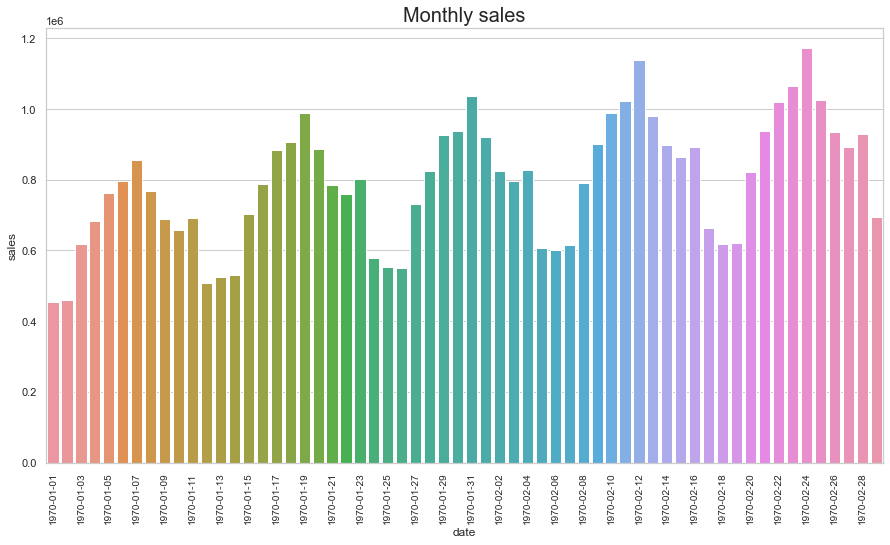

In [7]:
plt.rcParams['figure.figsize'] = (15, 8)

sns.set_theme(style="whitegrid")
sns.barplot(x="date", y="sales", data=monthlysales)
# sns.barplot(monthlysales['sales'], palette = 'hsv')
plt.title('Monthly sales', fontsize = 20)

xx = monthlysales.index.values.astype('datetime64[D]')
yy = monthlysales['sales']
ticks = np.arange(xx[0], xx[-1], (xx[-1] - xx[0]).astype('timedelta64[D]') / 20)
plt.xticks(ticks, ticks)
plt.gca().tick_params('x', labelrotation=90, labelsize=10)
plt.show()

In [8]:
#finding the number of days, and no. of years of dataset
def duration(data):
    data.date = pd.to_datetime(data.date)
    num_days = data.date.max() - data.date.min()
    num_years = num_days.days / 365
    print("Number of days: ",num_days.days,"days")
    print("Number of years: ",num_years,'years')
    
duration(traindat)

Number of days:  1825 days
Number of years:  5.0 years


Duration column ------------------------------------------------------------------------------------------


date  store  item  sales
21330 2016-05-29      2     2    139
21344 2016-06-12      2     2    131
21365 2016-07-03      2     2    138
21372 2016-07-10      2     2    134
21399 2016-08-06      2     2    136

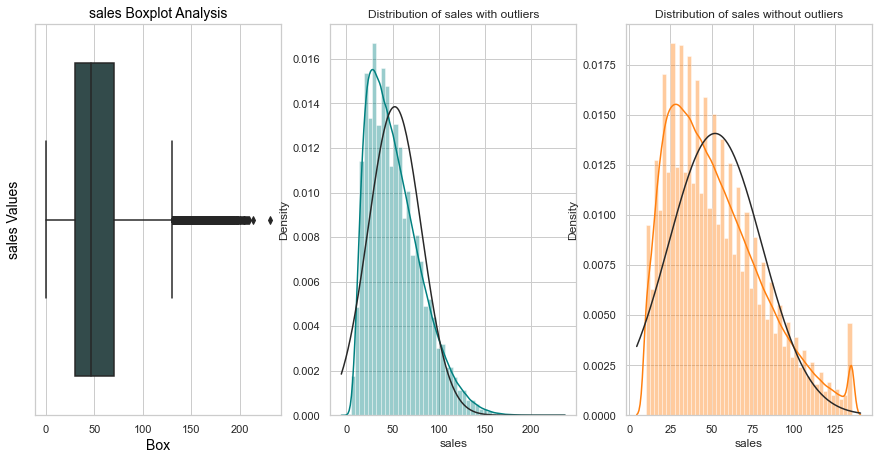

In [9]:
%run -i 'odp_plots.py'

# Outlier, distribution for 'duration' column
Q3 = traindat['sales'].quantile(0.75)
Q1 = traindat['sales'].quantile(0.25)
IQR = Q3 - Q1

print('Duration column', '--'*45)
display(traindat.loc[(traindat['sales'] < (Q1 - 1.5 * IQR)) | (traindat['sales'] > (Q3 + 1.5 * IQR))].head())

odp_plots(traindat, 'sales')


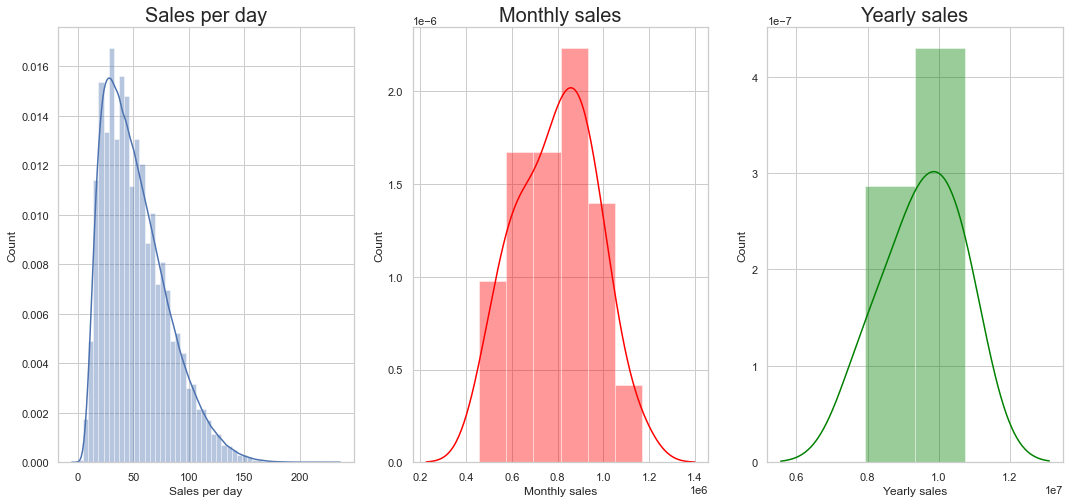

In [10]:
#sales for each day and monthly
plt.rcParams['figure.figsize'] = (18, 8)

plt.subplot(1, 3, 1)
sns.set(style = 'whitegrid')
sns.distplot(traindat['sales'])
plt.title('Sales per day', fontsize = 20)
plt.xlabel('Sales per day')
plt.ylabel('Count')

plt.subplot(1, 3, 2)
sns.set(style = 'whitegrid')
sns.distplot(monthlysales['sales'], color = 'red')
plt.title('Monthly sales', fontsize = 20)
plt.xlabel('Monthly sales')
plt.ylabel('Count')

plt.subplot(1, 3, 3)
sns.set(style = 'whitegrid')
sns.distplot(yrlysales['sales'], color = 'green')
plt.title('Yearly sales', fontsize = 20)
plt.xlabel('Yearly sales')
plt.ylabel('Count')
plt.show()

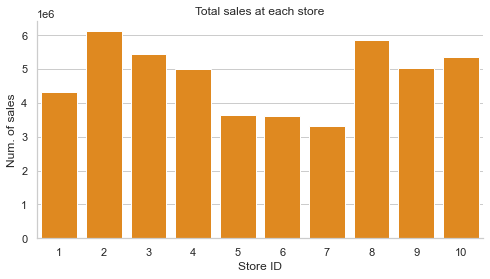

In [11]:
#sales per each store
def each_store_sales():
    ech_store = traindat.groupby('store')['sales'].sum().reset_index()
    
    fig, ax = plt.subplots(figsize=(8,4))
    sns.set(style = 'whitegrid')
    sns.barplot(ech_store.store,ech_store.sales,color='darkorange')
    ax.set(xlabel="Store ID",ylabel='Num. of sales',title='Total sales at each store')
    
    sns.despine()
    
each_store_sales()

In [12]:
# Average monthly sales
# Overall sales
avg_monthly_sales = monthlysales.sales.mean()
print(f"Overall average monthly sales: ${avg_monthly_sales}")

#last 12 months average
avg_last12months = monthlysales.sales[-12:].mean()
print(f"Last 12 months average sales: ${avg_last12months}")

Overall average monthly sales: $795075.2
Last 12 months average sales: $894478.3333333334


## Stationarity calc.

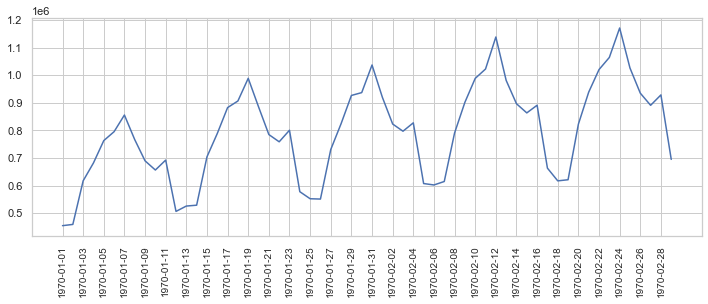

In [13]:
#monthly line plot
x = monthlysales.index.values.astype('datetime64[D]')
y = monthlysales['sales']
plt.figure(figsize=(12,4))
plt.plot(x, y)
ticks = np.arange(x[0], x[-1], (x[-1] - x[0]).astype('timedelta64[D]') / 20)
plt.xticks(ticks, ticks)
plt.gca().tick_params('x', labelrotation=90, labelsize=10)

Text(0.5, 1.0, 'Monthly Sales after differencing')

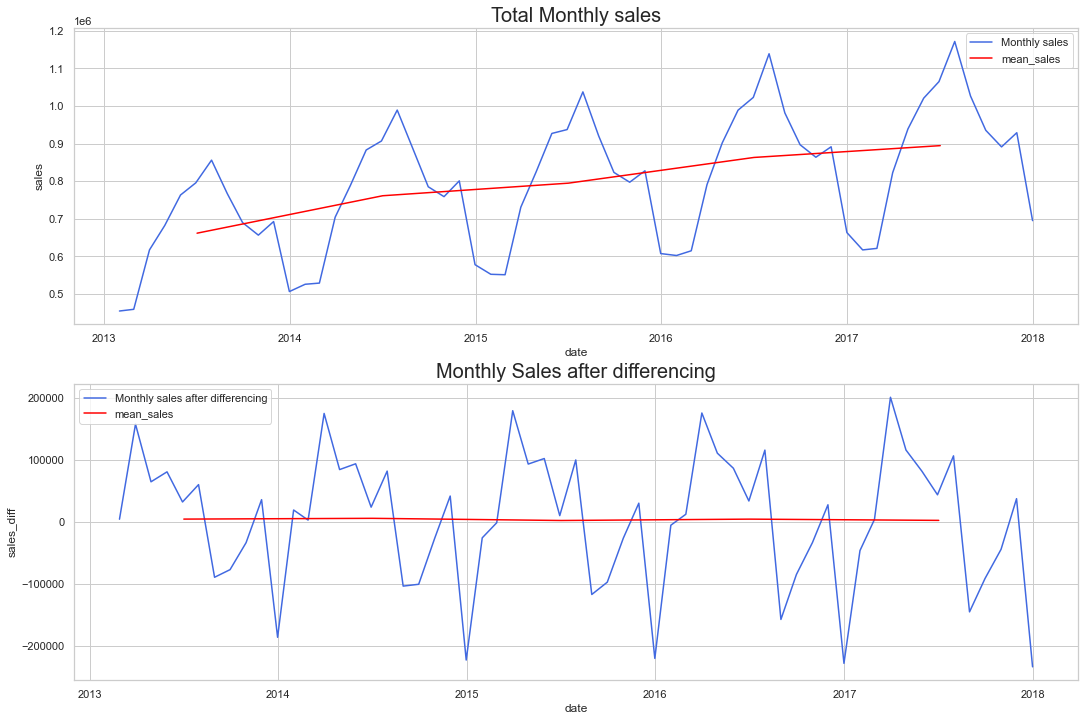

In [14]:
def diff_sales(data):
    data['sales_diff'] = data.sales.diff()
    data = data.dropna()
    
    data.to_csv("~/Downloads/sales_statinary_diff.csv")
    return data

stationary_df = diff_sales(monthlysales)

#sales for each day and monthly
plt.rcParams['figure.figsize'] = (18, 12)

plt.subplot(2,1,1)
sns.lineplot('date','sales',data=monthlysales,color='royalblue',label='Monthly sales')
yrly_sales = monthlysales.groupby(monthlysales.date.dt.year)['sales'].mean().reset_index()
yrly_sales.date = pd.to_datetime(yrly_sales.date,format='%Y')
sns.lineplot((yrly_sales.date+datetime.timedelta(6*365/12)),yrly_sales.sales,data=yrly_sales,
            color='red',label="mean_sales")
plt.title('Total Monthly sales', fontsize = 20)


plt.subplot(2,1,2)
sns.lineplot('date','sales_diff',data=stationary_df,color='royalblue',label='Monthly sales after differencing')
yrly_sales = stationary_df.groupby(stationary_df.date.dt.year)['sales_diff'].mean().reset_index()
yrly_sales.date = pd.to_datetime(yrly_sales.date,format='%Y')
sns.lineplot((yrly_sales.date+datetime.timedelta(6*365/12)),yrly_sales.sales_diff,data=stationary_df,
            color='red',label="mean_sales")
plt.title('Monthly Sales after differencing', fontsize = 20)


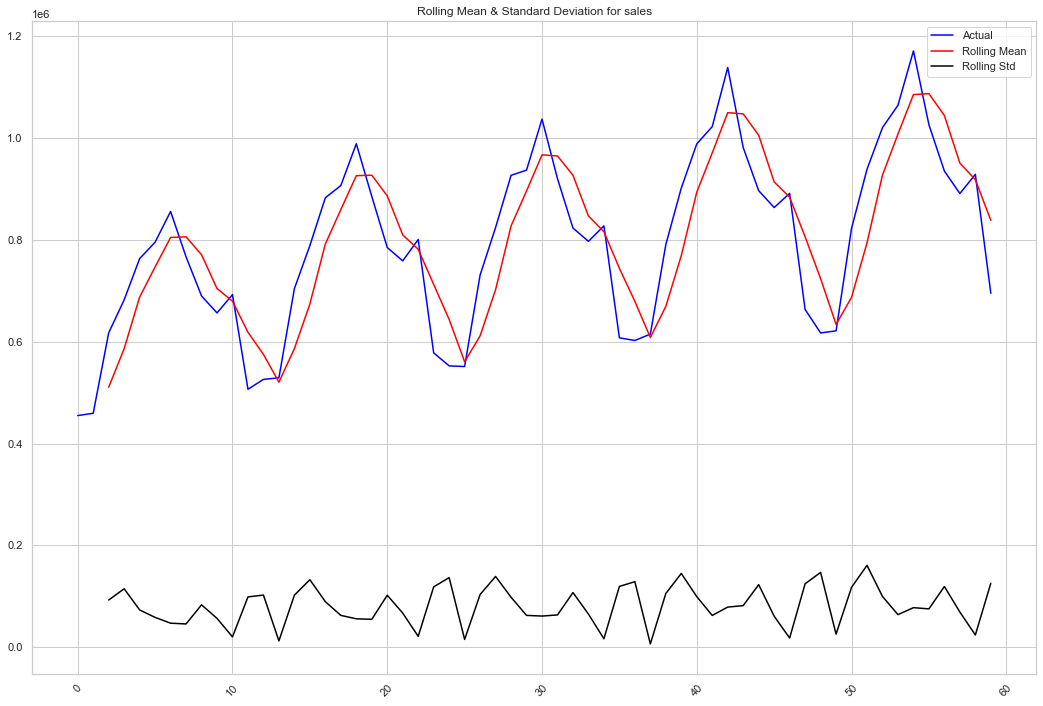

Results of Dickey-Fuller Test:
Test Statistic                 -5.247519
p-value                         0.000007
# Lags Used                    11.000000
Number of Observations Used    48.000000
Critical Value (1%)            -3.574589
Critical Value (5%)            -2.923954
Critical Value (10%)           -2.600039
dtype: float64


In [15]:
from statsmodels.tsa.stattools import adfuller
def stationarity_check(df, ts):
    
    # Determing rolling statistics
    rolmean = df[ts].rolling(window = 3, center = False).mean()
    rolstd = df[ts].rolling(window = 3, center = False).std()
    
    # Plot rolling statistics:
    orig = plt.plot(df[ts], 
                    color = 'blue', 
                    label = 'Actual')
    mean = plt.plot(rolmean, 
                    color = 'red', 
                    label = 'Rolling Mean')
    std = plt.plot(rolstd, 
                   color = 'black', 
                   label = 'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation for %s' %(ts))
    plt.xticks(rotation = 45)
    plt.show(block = False)
    plt.close()
    
    # Perform Dickey-Fuller test:
    # Null Hypothesis (H_0): time series is not stationary
    # Alternate Hypothesis (H_1): time series is stationary
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(df[ts], 
                      autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index = ['Test Statistic',
                                  'p-value',
                                  '# Lags Used',
                                  'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
stationarity_check(monthlysales,"sales")

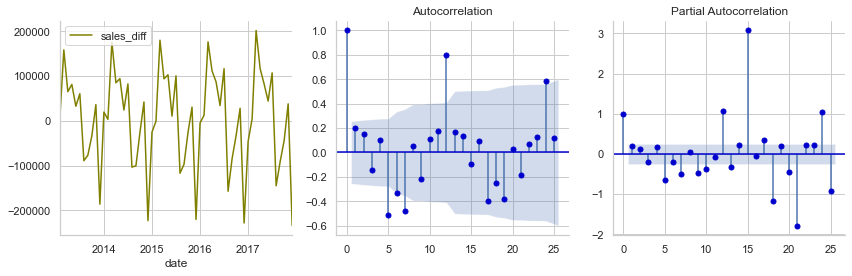

In [16]:
#Auto correlation function (ACF) and Partial auto correlation function (PACF)
def acf_pacf(data, lags=None):
    #convert dataframe to datetime index
    dt_data = data.set_index('date').drop('sales',axis=1)
    dt_data.dropna(axis=0)
    
    layout = (1,3)
    raw = plt.subplot2grid(layout, (0,0))
    acf = plt.subplot2grid(layout, (0,1))
    pacf = plt.subplot2grid(layout, (0,2))
    
    dt_data.plot(ax=raw, figsize=(12,4), color='olive')
    smt.graphics.plot_acf(dt_data, lags=lags, ax=acf, color='mediumblue')
    smt.graphics.plot_pacf(dt_data, lags=lags, ax=pacf, color="mediumblue")
    
    sns.despine()
    plt.tight_layout()
    
acf_pacf(stationary_df,lags=25)

In [17]:
model_df = arange_supervised(stationary_df)
model_df.head()

date   sales  sales_diff     lag_1     lag_2     lag_3     lag_4  \
0 2014-02-28  529117      3130.0   19380.0 -186036.0   36056.0  -33320.0   
1 2014-03-31  704301    175184.0    3130.0   19380.0 -186036.0   36056.0   
2 2014-04-30  788914     84613.0  175184.0    3130.0   19380.0 -186036.0   
3 2014-05-31  882877     93963.0   84613.0  175184.0    3130.0   19380.0   
4 2014-06-30  906842     23965.0   93963.0   84613.0  175184.0    3130.0   

      lag_5     lag_6    lag_7    lag_8    lag_9   lag_10    lag_11    lag_12  
0  -76854.0  -89161.0  60325.0  32355.0  80968.0  64892.0  157965.0    4513.0  
1  -33320.0  -76854.0 -89161.0  60325.0  32355.0  80968.0   64892.0  157965.0  
2   36056.0  -33320.0 -76854.0 -89161.0  60325.0  32355.0   80968.0   64892.0  
3 -186036.0   36056.0 -33320.0 -76854.0 -89161.0  60325.0   32355.0   80968.0  
4   19380.0 -186036.0  36056.0 -33320.0 -76854.0 -89161.0   60325.0   32355.0

### ARIMA model

In [18]:
dt_dat = stationary_df.set_index('date')
dt_dat.dropna(axis=0)
dt_dat.head()

sales  sales_diff
date                          
2013-02-28  459417      4513.0
2013-03-31  617382    157965.0
2013-04-30  682274     64892.0
2013-05-31  763242     80968.0
2013-06-30  795597     32355.0

In [19]:
dt_dat.index = pd.to_datetime(dt_dat.index)
dt_dat.head()

sales  sales_diff
date                          
2013-02-28  459417      4513.0
2013-03-31  617382    157965.0
2013-04-30  682274     64892.0
2013-05-31  763242     80968.0
2013-06-30  795597     32355.0

In [20]:
#ARIMA model
# from statsmodels.tsa.arima.model import ARIMA
# # fit model
# model = ARIMA(dt_dat.sales_diff, order=(5,1,0))
# model_fit = model.fit()
# # summary of fit model
# print(model_fit.summary())

#### SARIMAX modeling

RMSE: 14959.893468799997
MAE: 11265.335747416719
MSE: 223798412.59784484
R2 Score: 0.9835642876178377


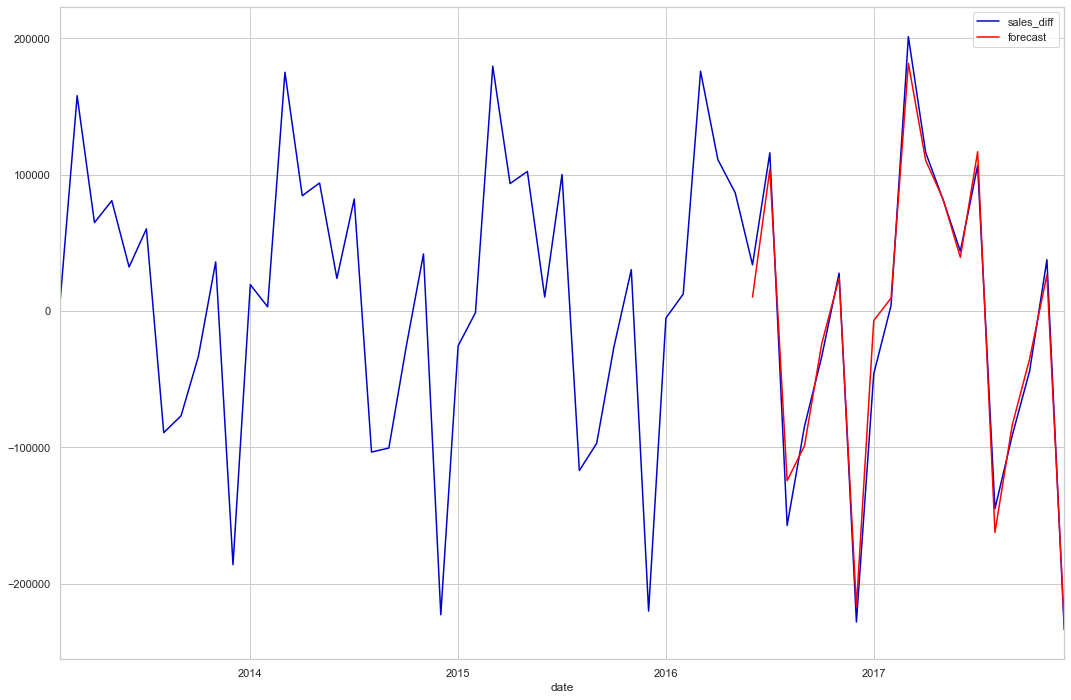

In [21]:
model_scores = {}
def get_scores(data):
    
    #model_scores = {}
    
    rmse = np.sqrt(mean_squared_error(data.sales_diff[-12:], data.forecast[-12:]))
    mae = mean_absolute_error(data.sales_diff[-12:], data.forecast[-12:])
    #calc. Mean Squared Error
    mse = mean_squared_error(data.sales_diff[-12:],data.forecast[-12:])
    r2 = r2_score(data.sales_diff[-12:], data.forecast[-12:])
    model_scores['ARIMA'] = [rmse, mae, mse, r2]
    
    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"R2 Score: {r2}")
    
    pickle.dump(model_scores, open( "/Users/preethamvignesh/Downloads/arima_model_scores.pkl", "wb" ))
    
def sarimax_model(data):
    
    # Model
    sarmax = sm.tsa.statespace.SARIMAX(dt_dat.sales_diff, order=(12,0,0), seasonal_order=(0,1,0,12), trend='c').fit()

    # Predictions
    start, end, dynamic = 40, 100, 7
    data['forecast'] = sarmax.predict(start=start, end=end, dynamic=dynamic) 
    pred_df = data.forecast[start+dynamic:end]
    
    data[['sales_diff', 'forecast']].plot(color=['mediumblue', 'Red'])
    
    get_scores(data)

    return sarmax, data, pred_df

sarmax, dt_dat, predictions = sarimax_model(dt_dat)

In [22]:
sarmax.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                          sales_diff   No. Observations:                   59
Model:             SARIMAX(12, 0, 0)x(0, 1, 0, 12)   Log Likelihood                -520.381
Date:                             Mon, 08 Mar 2021   AIC                           1068.761
Time:                                     12:01:09   BIC                           1094.663
Sample:                                 02-28-2013   HQIC                          1078.508
                                      - 12-31-2017                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -739.1753   1700.249     -0.435      0.664   -4071.602    2593.251
ar.L1          0.0035      0.104      0.034      0.973      -0.200       0.207
ar.L2         -0.0713      0.112     -0.636      0.525      -0.291       0.148
ar.L3          0.0158      0.137      0.116      0.908      -0.252       0.284
ar.L4         -0.0092      0.099     -0.093      0.926      -0.203       0.184
ar.L5          0.0531      0.072      0.740      0.459      -0.088       0.194
ar.L6          0.0268      0.083      0.324      0.746      -0.135       0.189
ar.L7         -0.1364      0.055     -2.459      0.014      -0.245      -0.028
ar.L8         -0.0202      0.074     -0.274      0.784      -0.165       0.124
ar.L9          0.0284      0.089      0.318      0.750      -0.147       0.204
ar.L10        -0.0559      0.092     -0.605      0.545      -0.237       0.125
ar.L11         0.0193      0.060      0.321      0.748      -0.099       0.137
ar.L12         0.1266      0.051      2.460      0.014       0.026       0.227
sigma2      1.253e+08      0.047   2.69e+09      0.000    1.25e+08    1.25e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):                10.54
Prob(Q):                              0.66   Prob(JB):                         0.01
Heteroskedasticity (H):               0.95   Skew:                            -0.89
Prob(H) (two-sided):                  0.93   Kurtosis:                         4.48
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.67e+24. Standard errors may be unstable.
"""

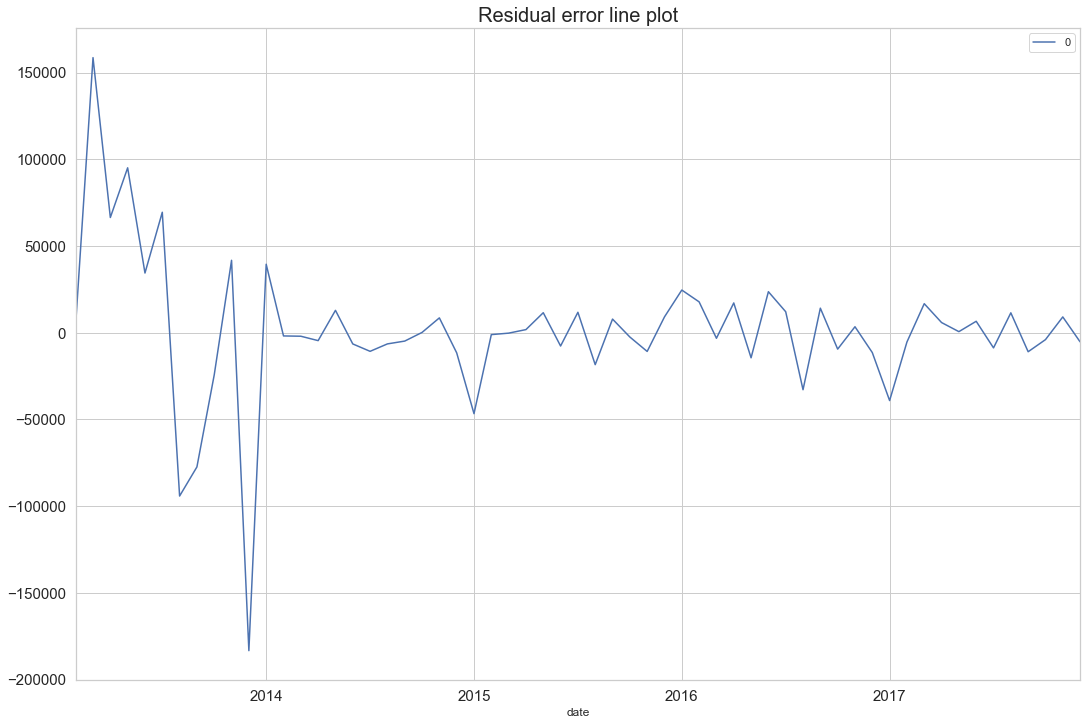

In [23]:
# line plot of residuals
from pandas import DataFrame
residuals = DataFrame(sarmax.resid)
residuals.plot()
plt.title("Residual error line plot",fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.show()

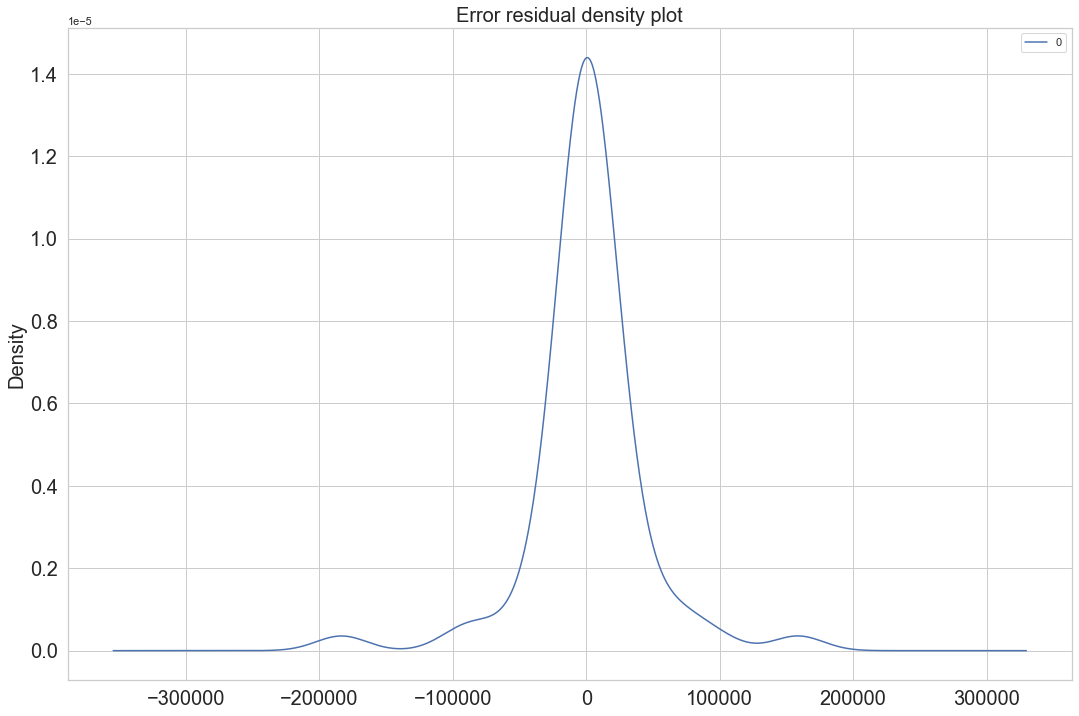

                   0
count      59.000000
mean     1353.044215
std     42899.968671
min   -183338.596618
25%     -9065.833792
50%      -207.708104
75%     11981.857811
max    158703.158848


In [24]:
# density plot of residuals
residuals.plot(kind='kde')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.ylabel("Density",fontsize=20)
plt.title("Error residual density plot",fontsize=20)
plt.show()

# summary stats of residuals
print(residuals.describe())

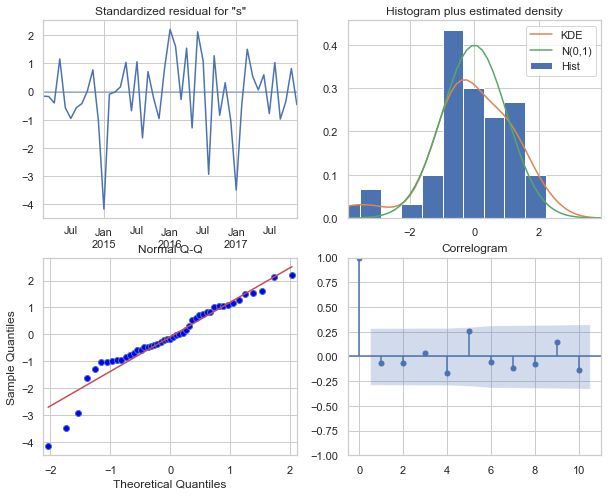

In [25]:
sarmax.plot_diagnostics(figsize=(10, 8));

In [26]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    

    plt.savefig(f'/Users/preethamvignesh/Downloads/{model_name}_forecast.png')

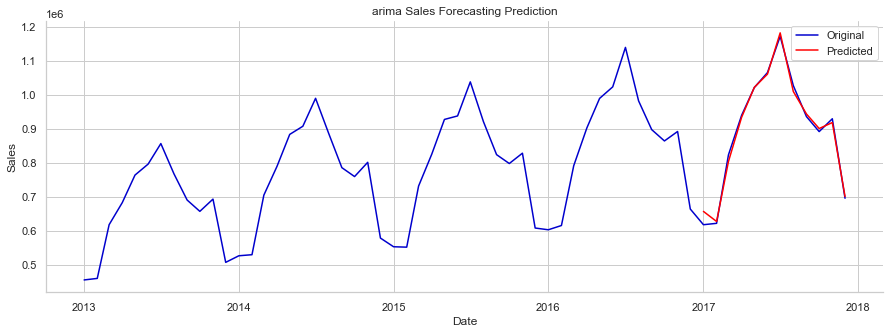

In [27]:
prediction_df, original_df = predict_df(predictions)
plot_results(prediction_df, original_df, 'arima')

In [28]:
print(model_scores)

{'ARIMA': [14959.893468799997, 11265.335747416719, 223798412.59784484, 0.9835642876178377]}


In [29]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['ARIMA'][0]})
mae1 = list({model_scores['ARIMA'][1]})
mse1 = list({model_scores['ARIMA'][2]})
r21 = list({model_scores['ARIMA'][3]})
results_temp = pd.DataFrame({'Method':['ARIMA'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'1'})
# resultsapp = pd.concat([results,results_temp])
results = results_temp[['Method','RMSE','MAE','MSE','R_square']]

results

Method          RMSE           MAE           MSE  R_square
1  ARIMA  14959.893469  11265.335747  2.237984e+08  0.983564

#### Models: Linear Reg (LReg), Random Forest (RF), XG Boost, and LSTM

In [30]:
#Loading the model fit values
mdl_df = pd.read_csv('~/Downloads/model_df.csv')

#Train and Split the datasets
data = mdl_df.drop(['sales','date'],axis=1)
train, test = data[0:-12].values,data[-12:].values
train.shape,test.shape

((35, 13), (12, 13))

In [31]:
def scale_data(train_set, test_set):
    #apply Min Max Scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train_set)
    
    # reshape training set
    train_set = train_set.reshape(train_set.shape[0], train_set.shape[1])
    train_set_scaled = scaler.transform(train_set)
    
    # reshape test set
    test_set = test_set.reshape(test_set.shape[0], test_set.shape[1])
    test_set_scaled = scaler.transform(test_set)
    
    X_train, y_train = train_set_scaled[:, 1:], train_set_scaled[:, 0:1].ravel()
    X_test, y_test = test_set_scaled[:, 1:], test_set_scaled[:, 0:1].ravel()
    
    return X_train, y_train, X_test, y_test, scaler

X_train, y_train, X_test, y_test, scaler_object = scale_data(train, test)

y_train.shape

(35,)

In [32]:
# Modeling functions
def undo_scaling(y_pred, x_test, scaler_obj, lstm=False):  
    #reshape y_pred
    y_pred = y_pred.reshape(y_pred.shape[0], 1, 1)
    
    if not lstm:
        x_test = x_test.reshape(x_test.shape[0], 1, x_test.shape[1])
    
    #rebuild test set for inverse transform
    pred_test_set = []
    for index in range(0,len(y_pred)):
        pred_test_set.append(np.concatenate([y_pred[index],x_test[index]],axis=1))
        
    #reshape pred_test_set
    pred_test_set = np.array(pred_test_set)
    pred_test_set = pred_test_set.reshape(pred_test_set.shape[0], pred_test_set.shape[2])
    
    #inverse transform
    pred_test_set_inverted = scaler_obj.inverse_transform(pred_test_set)
    
    return pred_test_set_inverted

In [33]:
def load_original_df():
    #load in original dataframe without scaling applied
    original_df = pd.read_csv('~/Desktop/Work/ML_EIT/Data/tseries_train.csv')
    original_df.date = original_df.date.apply(lambda x: str(x)[:-3])
    original_df = original_df.groupby('date')['sales'].sum().reset_index()
    original_df.date = pd.to_datetime(original_df.date)
    return original_df

In [34]:
def predict_df(unscaled_predictions, original_df):
    #create dataframe that shows the predicted sales
    result_list = []
    sales_dates = list(original_df[-13:].date)
    act_sales = list(original_df[-13:].sales)
    
    for index in range(0,len(unscaled_predictions)):
        result_dict = {}
        result_dict['pred_value'] = int(unscaled_predictions[index][0] + act_sales[index])
        result_dict['date'] = sales_dates[index+1]
        result_list.append(result_dict)
        
    df_result = pd.DataFrame(result_list)
    
    return df_result

In [35]:
model_scores = {}

def get_scores(unscaled_df, original_df, model_name):
    #calc. of Root Mean Squared Error
    rmse = np.sqrt(mean_squared_error(original_df.sales[-12:], unscaled_df.pred_value[-12:]))
    #calc. of Mean Absolute Error
    mae = mean_absolute_error(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    #calc. Mean Squared Error
    mse = mean_squared_error(original_df.sales[-12:],unscaled_df.pred_value[-12:])
    #calc. of R2 value
    r2 = r2_score(original_df.sales[-12:], unscaled_df.pred_value[-12:])
    model_scores[model_name] = [rmse, mae, mse, r2]

    print(f"RMSE: {rmse}")
    print(f"MAE: {mae}")
    print(f"MSE: {mse}")
    print(f"R2 Score: {r2}")
    

In [36]:
def plot_results(results, original_df, model_name):

    fig, ax = plt.subplots(figsize=(15,5))
    sns.lineplot(original_df.date, original_df.sales, data=original_df, ax=ax, 
                 label='Original', color='mediumblue')
    sns.lineplot(results.date, results.pred_value, data=results, ax=ax, 
                 label='Predicted', color='Red')
    
    ax.set(xlabel = "Date",
           ylabel = "Sales",
           title = f"{model_name} Sales Forecasting Prediction")
    
    ax.legend()
    
    sns.despine()
    
    plt.savefig(f'/Users/preethamvignesh/Downloads/{model_name}_forecast.png')

In [37]:
def run_model(train_data, test_data, model, model_name):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    mod = model
    mod.fit(X_train, y_train)
    predictions = mod.predict(X_test)
    
    # Undo scaling to compare predictions against original data
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object)
    unscaled_df = predict_df(unscaled, original_df)
      
    get_scores(unscaled_df, original_df, model_name)
    
    plot_results(unscaled_df, original_df, model_name)

#### Linear Regression

RMSE: 16221.040790693221
MAE: 12433.0
MSE: 263122164.33333334
R2 Score: 0.9907155879704752


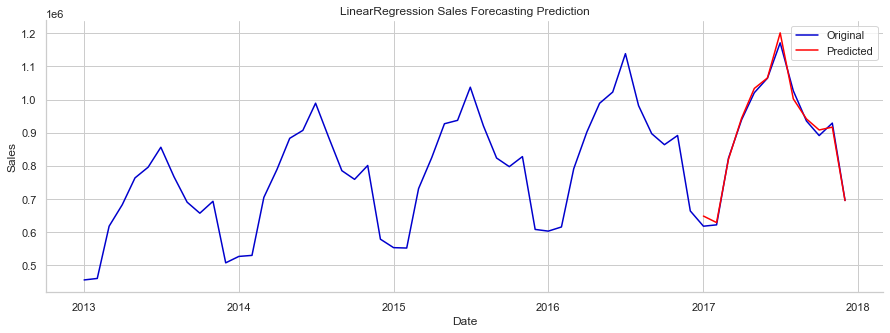

In [38]:
run_model(train, test, LinearRegression(), 'LinearRegression')

In [39]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['LinearRegression'][0]})
mae1 = list({model_scores['LinearRegression'][1]})
mse1 = list({model_scores['LinearRegression'][2]})
r21 = list({model_scores['LinearRegression'][3]})
results_temp = pd.DataFrame({'Method':['Linear Regression'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'2'})
results = pd.concat([results,results_temp])
results = results[['Method','RMSE','MAE','MSE','R_square']]

results

Method          RMSE           MAE           MSE  R_square
1              ARIMA  14959.893469  11265.335747  2.237984e+08  0.983564
2  Linear Regression  16221.040791  12433.000000  2.631222e+08  0.990716

#### Random Forest Regressor

RMSE: 19453.765987163857
MAE: 16064.25
MSE: 378449011.0833333
R2 Score: 0.9866462159888112


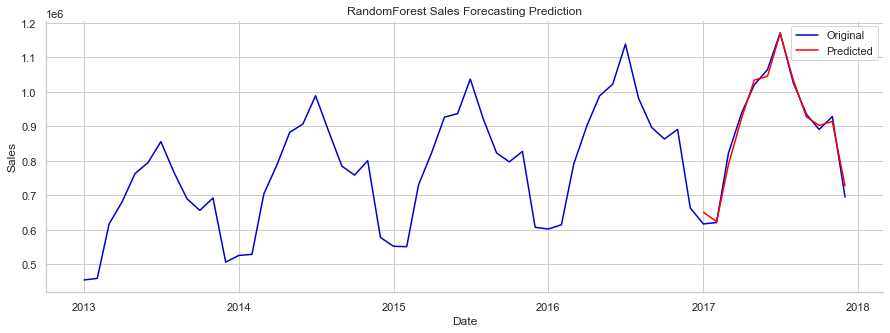

In [40]:
run_model(train, test, RandomForestRegressor(n_estimators=100, max_depth=20), 
          'RandomForest')

In [41]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['RandomForest'][0]})
mae1 = list({model_scores['RandomForest'][1]})
mse1 = list({model_scores['RandomForest'][2]})
r21 = list({model_scores['RandomForest'][3]})
results_temp = pd.DataFrame({'Method':['Random Forest'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'3'})
results = pd.concat([results,results_temp])
results = results[['Method','RMSE','MAE','MSE','R_square']]

results

Method          RMSE           MAE           MSE  R_square
1              ARIMA  14959.893469  11265.335747  2.237984e+08  0.983564
2  Linear Regression  16221.040791  12433.000000  2.631222e+08  0.990716
3      Random Forest  19453.765987  16064.250000  3.784490e+08  0.986646

#### DecisionTreeRegressor

RMSE: 19842.038840132667
MAE: 16554.166666666668
MSE: 393706505.3333333
R2 Score: 0.9861078468114596


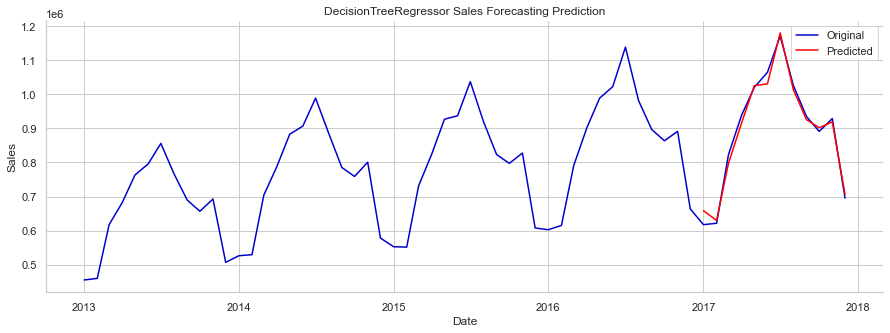

In [42]:
run_model(train, test, DecisionTreeRegressor(), 'DecisionTreeRegressor')

In [43]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['DecisionTreeRegressor'][0]})
mae1 = list({model_scores['DecisionTreeRegressor'][1]})
mse1 = list({model_scores['DecisionTreeRegressor'][2]})
r21 = list({model_scores['DecisionTreeRegressor'][3]})
results_temp = pd.DataFrame({'Method':['DecisionTreeRegressor'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'4'})
results = pd.concat([results,results_temp])
results = results[['Method','RMSE','MAE','MSE','R_square']]

results

Method          RMSE           MAE           MSE  R_square
1                  ARIMA  14959.893469  11265.335747  2.237984e+08  0.983564
2      Linear Regression  16221.040791  12433.000000  2.631222e+08  0.990716
3          Random Forest  19453.765987  16064.250000  3.784490e+08  0.986646
4  DecisionTreeRegressor  19842.038840  16554.166667  3.937065e+08  0.986108

#### Gradient Boost Regressor

RMSE: 15080.361730299
MAE: 12544.916666666666
MSE: 227417309.91666666
R2 Score: 0.9919754536328699


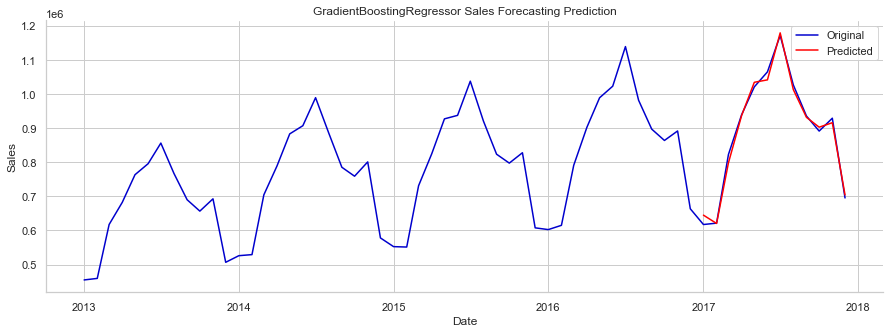

In [44]:
run_model(train, test, GradientBoostingRegressor(), 'GradientBoostingRegressor')

In [45]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['GradientBoostingRegressor'][0]})
mae1 = list({model_scores['GradientBoostingRegressor'][1]})
mse1 = list({model_scores['GradientBoostingRegressor'][2]})
r21 = list({model_scores['GradientBoostingRegressor'][3]})
results_temp = pd.DataFrame({'Method':['GradientBoostingRegressor'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'5'})
results = pd.concat([results,results_temp])
results = results[['Method','RMSE','MAE','MSE','R_square']]

results

Method          RMSE           MAE           MSE  \
1                      ARIMA  14959.893469  11265.335747  2.237984e+08   
2          Linear Regression  16221.040791  12433.000000  2.631222e+08   
3              Random Forest  19453.765987  16064.250000  3.784490e+08   
4      DecisionTreeRegressor  19842.038840  16554.166667  3.937065e+08   
5  GradientBoostingRegressor  15080.361730  12544.916667  2.274173e+08   

   R_square  
1  0.983564  
2  0.990716  
3  0.986646  
4  0.986108  
5  0.991975

#### Ada Boost Regressor

RMSE: 16088.073716783705
MAE: 14509.25
MSE: 258826115.91666666
R2 Score: 0.9908671764301558


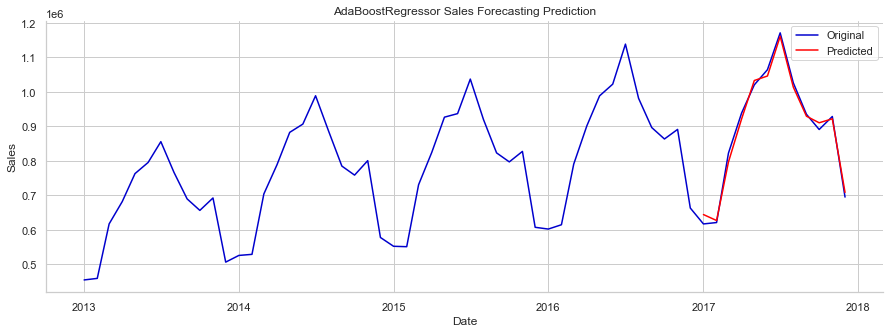

In [46]:
run_model(train, test, AdaBoostRegressor(), 'AdaBoostRegressor')

In [47]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['AdaBoostRegressor'][0]})
mae1 = list({model_scores['AdaBoostRegressor'][1]})
mse1 = list({model_scores['AdaBoostRegressor'][2]})
r21 = list({model_scores['AdaBoostRegressor'][3]})
results_temp = pd.DataFrame({'Method':['AdaBoostRegressor'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'6'})
results = pd.concat([results,results_temp])
results = results[['Method','RMSE','MAE','MSE','R_square']]

results

Method          RMSE           MAE           MSE  \
1                      ARIMA  14959.893469  11265.335747  2.237984e+08   
2          Linear Regression  16221.040791  12433.000000  2.631222e+08   
3              Random Forest  19453.765987  16064.250000  3.784490e+08   
4      DecisionTreeRegressor  19842.038840  16554.166667  3.937065e+08   
5  GradientBoostingRegressor  15080.361730  12544.916667  2.274173e+08   
6          AdaBoostRegressor  16088.073717  14509.250000  2.588261e+08   

   R_square  
1  0.983564  
2  0.990716  
3  0.986646  
4  0.986108  
5  0.991975  
6  0.990867

### XG Boost

RMSE: 15701.003359658262
MAE: 13342.666666666666
MSE: 246521506.5
R2 Score: 0.9913013514225064


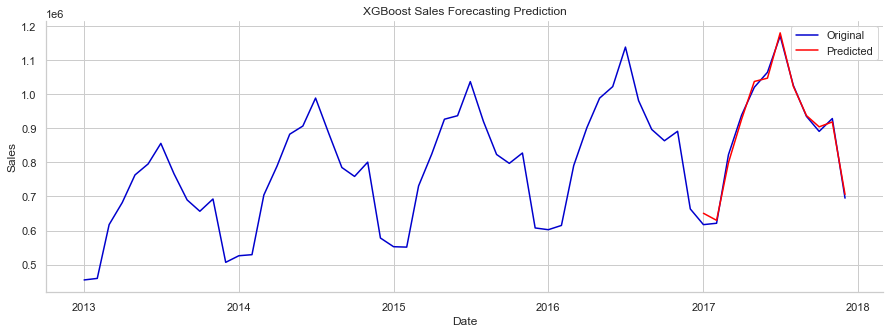

In [48]:
run_model(train, test, XGBRegressor( n_estimators=100, 
                                    learning_rate=0.2, 
                                    objective='reg:squarederror'), 'XGBoost')

In [49]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['XGBoost'][0]})
mae1 = list({model_scores['XGBoost'][1]})
mse1 = list({model_scores['XGBoost'][2]})
r21 = list({model_scores['XGBoost'][3]})
results_temp = pd.DataFrame({'Method':['XGBoost'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'7'})
results = pd.concat([results,results_temp])
results = results[['Method','RMSE','MAE','MSE','R_square']]

results

Method          RMSE           MAE           MSE  \
1                      ARIMA  14959.893469  11265.335747  2.237984e+08   
2          Linear Regression  16221.040791  12433.000000  2.631222e+08   
3              Random Forest  19453.765987  16064.250000  3.784490e+08   
4      DecisionTreeRegressor  19842.038840  16554.166667  3.937065e+08   
5  GradientBoostingRegressor  15080.361730  12544.916667  2.274173e+08   
6          AdaBoostRegressor  16088.073717  14509.250000  2.588261e+08   
7                    XGBoost  15701.003360  13342.666667  2.465215e+08   

   R_square  
1  0.983564  
2  0.990716  
3  0.986646  
4  0.986108  
5  0.991975  
6  0.990867  
7  0.991301

### KNeighborsRegressor (KNN Regressor)

RMSE: 17675.47813591851
MAE: 14580.0
MSE: 312422527.3333333
R2 Score: 0.9889759972200841


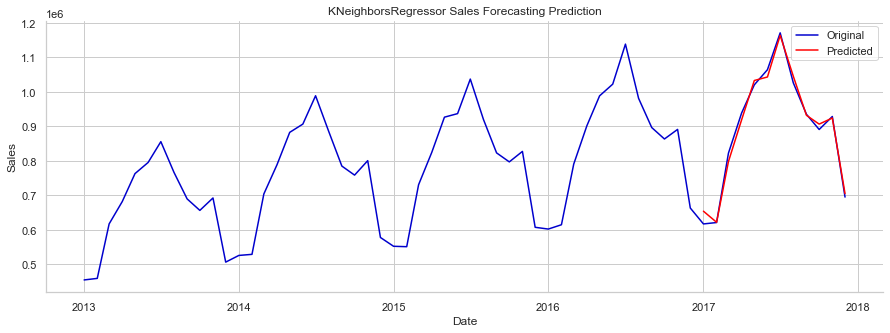

In [50]:
run_model(train, test, KNeighborsRegressor(n_neighbors=3), 'KNeighborsRegressor')

In [51]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['KNeighborsRegressor'][0]})
mae1 = list({model_scores['KNeighborsRegressor'][1]})
mse1 = list({model_scores['KNeighborsRegressor'][2]})
r21 = list({model_scores['KNeighborsRegressor'][3]})
results_temp = pd.DataFrame({'Method':['KNeighborsRegressor'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'8'})
results = pd.concat([results,results_temp])
results = results[['Method','RMSE','MAE','MSE','R_square']]

results

Method          RMSE           MAE           MSE  \
1                      ARIMA  14959.893469  11265.335747  2.237984e+08   
2          Linear Regression  16221.040791  12433.000000  2.631222e+08   
3              Random Forest  19453.765987  16064.250000  3.784490e+08   
4      DecisionTreeRegressor  19842.038840  16554.166667  3.937065e+08   
5  GradientBoostingRegressor  15080.361730  12544.916667  2.274173e+08   
6          AdaBoostRegressor  16088.073717  14509.250000  2.588261e+08   
7                    XGBoost  15701.003360  13342.666667  2.465215e+08   
8        KNeighborsRegressor  17675.478136  14580.000000  3.124225e+08   

   R_square  
1  0.983564  
2  0.990716  
3  0.986646  
4  0.986108  
5  0.991975  
6  0.990867  
7  0.991301  
8  0.988976

#### Support Vector Regressor

RMSE: 18781.218768138202
MAE: 14618.916666666666
MSE: 352734178.4166667
R2 Score: 0.9875535781730366


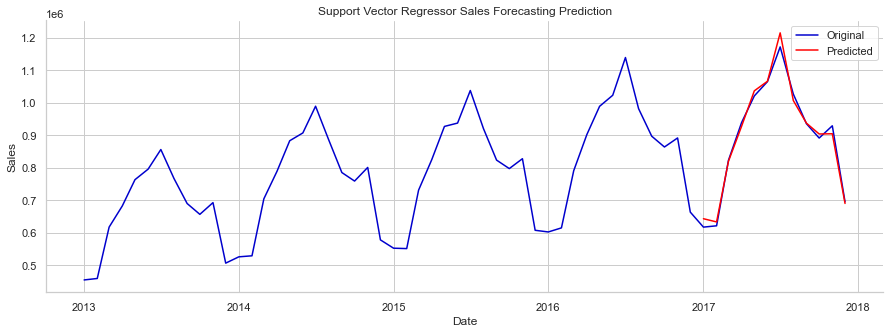

In [52]:
run_model(train, test, SVR(kernel='linear'), 'Support Vector Regressor')

In [53]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['Support Vector Regressor'][0]})
mae1 = list({model_scores['Support Vector Regressor'][1]})
mse1 = list({model_scores['Support Vector Regressor'][2]})
r21 = list({model_scores['Support Vector Regressor'][3]})
results_temp = pd.DataFrame({'Method':['Support Vector Regressor'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'9'})
results = pd.concat([results,results_temp])
results = results[['Method','RMSE','MAE','MSE','R_square']]

results

Method          RMSE           MAE           MSE  \
1                      ARIMA  14959.893469  11265.335747  2.237984e+08   
2          Linear Regression  16221.040791  12433.000000  2.631222e+08   
3              Random Forest  19453.765987  16064.250000  3.784490e+08   
4      DecisionTreeRegressor  19842.038840  16554.166667  3.937065e+08   
5  GradientBoostingRegressor  15080.361730  12544.916667  2.274173e+08   
6          AdaBoostRegressor  16088.073717  14509.250000  2.588261e+08   
7                    XGBoost  15701.003360  13342.666667  2.465215e+08   
8        KNeighborsRegressor  17675.478136  14580.000000  3.124225e+08   
9   Support Vector Regressor  18781.218768  14618.916667  3.527342e+08   

   R_square  
1  0.983564  
2  0.990716  
3  0.986646  
4  0.986108  
5  0.991975  
6  0.990867  
7  0.991301  
8  0.988976  
9  0.987554

### LSTM

In [54]:
def lstm_model(train_data, test_data):
    
    X_train, y_train, X_test, y_test, scaler_object = scale_data(train_data, test_data)
    
    X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])
   
    model = Sequential()
    model.add(LSTM(4, batch_input_shape=(1, X_train.shape[1], X_train.shape[2]), 
                   stateful=True))
    model.add(Dense(1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.fit(X_train, y_train, epochs=200, batch_size=1, verbose=1, 
              shuffle=False)
    predictions = model.predict(X_test,batch_size=1)
    
    original_df = load_original_df()
    unscaled = undo_scaling(predictions, X_test, scaler_object, lstm=True)
    unscaled_df = predict_df(unscaled, original_df)
    
    get_scores(unscaled_df, original_df, 'LSTM')
    
    plot_results(unscaled_df, original_df, 'LSTM')

Epoch 1/200
35/35 [==============================] - 2s 2ms/step - loss: 0.2980
Epoch 2/200
35/35 [==============================] - 0s 2ms/step - loss: 0.3273
Epoch 3/200
35/35 [==============================] - 0s 2ms/step - loss: 0.2941
Epoch 4/200
35/35 [==============================] - 0s 3ms/step - loss: 0.2603
Epoch 5/200
35/35 [==============================] - 0s 3ms/step - loss: 0.2293
Epoch 6/200
35/35 [==============================] - 0s 2ms/step - loss: 0.2016
Epoch 7/200
35/35 [==============================] - 0s 2ms/step - loss: 0.1772
Epoch 8/200
35/35 [==============================] - 0s 2ms/step - loss: 0.1560
Epoch 9/200
35/35 [==============================] - 0s 2ms/step - loss: 0.1377
Epoch 10/200
35/35 [==============================] - 0s 2ms/step - loss: 0.1218
Epoch 11/200
35/35 [==============================] - 0s 2ms/step - loss: 0.1082
Epoch 12/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0963
Epoch 13/200
35/35 [=================

35/35 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 103/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0055
Epoch 104/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0054
Epoch 105/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 106/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0053
Epoch 107/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 108/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0052
Epoch 109/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 110/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0051
Epoch 111/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 112/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0050
Epoch 113/200
35/35 [==============================] - 0s 2ms/step - loss: 0.0049
Epoch 114/200
35/35 [=========

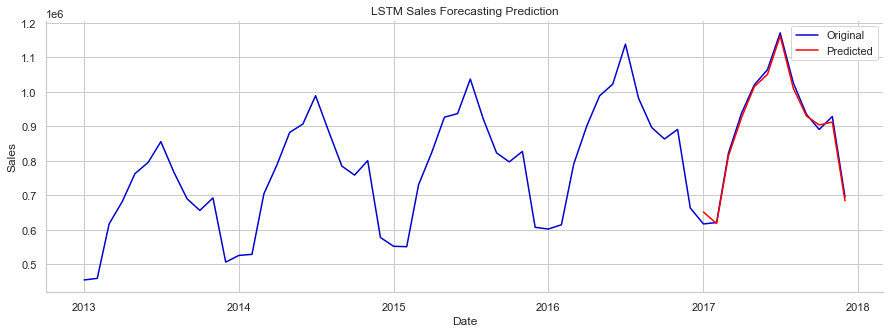

In [55]:
lstm_model(train, test)

In [56]:
#store the model results for each model data frame for final comparison
rmse1 = list({model_scores['LSTM'][0]})
mae1 = list({model_scores['LSTM'][1]})
mse1 = list({model_scores['LSTM'][2]})
r21 = list({model_scores['LSTM'][3]})
results_temp = pd.DataFrame({'Method':['LSTM'],'RMSE':rmse1,
                            'MAE':mae1,'MSE':mse1,'MSE':mse1,
                            'R_square':r21},index={'10'})
results = pd.concat([results,results_temp])
results = results[['Method','RMSE','MAE','MSE','R_square']]

results

Method          RMSE           MAE           MSE  \
1                       ARIMA  14959.893469  11265.335747  2.237984e+08   
2           Linear Regression  16221.040791  12433.000000  2.631222e+08   
3               Random Forest  19453.765987  16064.250000  3.784490e+08   
4       DecisionTreeRegressor  19842.038840  16554.166667  3.937065e+08   
5   GradientBoostingRegressor  15080.361730  12544.916667  2.274173e+08   
6           AdaBoostRegressor  16088.073717  14509.250000  2.588261e+08   
7                     XGBoost  15701.003360  13342.666667  2.465215e+08   
8         KNeighborsRegressor  17675.478136  14580.000000  3.124225e+08   
9    Support Vector Regressor  18781.218768  14618.916667  3.527342e+08   
10                       LSTM  14603.504825  12302.833333  2.132624e+08   

    R_square  
1   0.983564  
2   0.990716  
3   0.986646  
4   0.986108  
5   0.991975  
6   0.990867  
7   0.991301  
8   0.988976  
9   0.987554  
10  0.992475

In [57]:
results.shape

(10, 5)

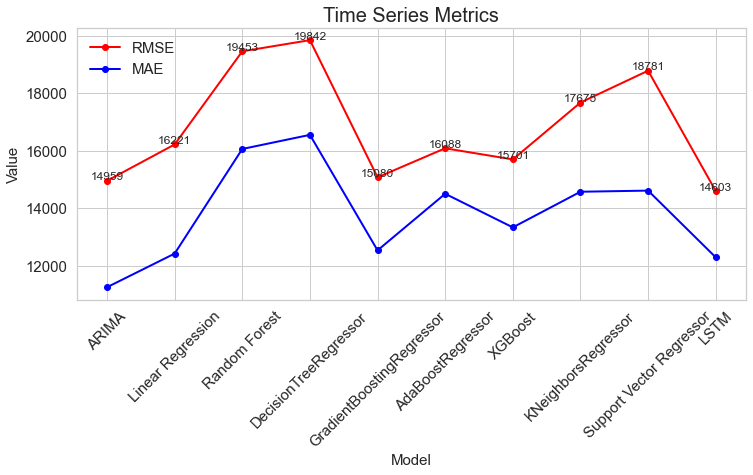

In [58]:
#RMSE and MSE plot
# plt.figure(figsize=(8,5))
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(111)
xval = results.Method
yval = results.RMSE
plt.xticks(fontsize=15,rotation = 45)
plt.yticks(fontsize=15)
line1,=plt.plot(xval,yval,marker='o',linewidth=2,color='red',label='RMSE')
line2,=plt.plot(results.Method,results.MAE,marker='o',linewidth=2,color='blue',label='MAE')

for i, v in enumerate(yval):
    ax.text(i, v+25, "%d" %v, ha="center")
plt.title("Time Series Metrics",fontsize=20)
plt.ylabel('Value',fontsize=15)
plt.xlabel('Model',fontsize=15)
ax.legend(loc='upper left', frameon=False,fontsize=15)
